### Project Goal
To predict the number of remaining operational cycles before failure

### Imports

In [1]:
import sagemaker
import boto3
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import io
import os

%matplotlib inline

bucket = "pm-rodrigo-bucket"

### Read in Data

In [174]:
def read_labels(file_name):

    s3 = boto3.client('s3') 

    obj = s3.get_object(Bucket= bucket, Key= file_name) 

    df = pd.read_csv(obj['Body'],header=None, delimiter=" ", low_memory=False)
    
    df.columns = ['Failure_Cycle','D']
    return df

def read_data(file_name):

    s3 = boto3.client('s3') 

    obj = s3.get_object(Bucket= bucket, Key= file_name) 

    df = pd.read_csv(obj['Body'],header=None, delimiter=" ", low_memory=False)

    ss = ['unit_number','cycle','os1','os2','os3',]
    ss.extend(['sensor_{}'.format(i+1) for i in range(23)])
    df.columns = ss
    return df

In [175]:
labs_df1 = read_labels("data/RUL_FD001.txt")
labs_df2 = read_labels("data/RUL_FD002.txt")
labs_df3 = read_labels("data/RUL_FD003.txt")
labs_df4 = read_labels("data/RUL_FD004.txt")

test_df1 = read_data("data/test_FD001.txt")
test_df2 = read_data("data/test_FD002.txt")
test_df3 = read_data("data/test_FD003.txt")
test_df4 = read_data("data/test_FD004.txt")

train_df1 = read_data("data/train_FD001.txt")
train_df2 = read_data("data/train_FD002.txt")
train_df3 = read_data("data/train_FD003.txt")
train_df4 = read_data("data/train_FD004.txt")

In [176]:
print('1')
print(len(labs_df1))
print(len(test_df1['unit_number'].value_counts()))
print(len(train_df1['unit_number'].value_counts()))

print('2')
print(len(labs_df2))
print(len(test_df2['unit_number'].value_counts()))
print(len(train_df2['unit_number'].value_counts()))

print('3')
print(len(labs_df3))
print(len(test_df3['unit_number'].value_counts()))
print(len(train_df3['unit_number'].value_counts()))

print('4')
print(len(labs_df4))
print(len(test_df4['unit_number'].value_counts()))
print(len(train_df4['unit_number'].value_counts()))

1
100
100
100
2
259
259
260
3
100
100
100
4
248
248
249


In [177]:
# We reset the indexes on the RUL files which correspond to the unit numbers:
def fix_lab(df):
    tst = df.copy()
    tst.reset_index(inplace=True)
    tst.drop(['D'],axis=1,inplace=True)
    tst.columns = ['unit_number','Failure_Cycle']
    tst['unit_number'] = tst['unit_number'].apply(lambda x: x+1)
    return tst

In [178]:
labs_df1 = fix_lab(labs_df1)
labs_df2 = fix_lab(labs_df2)
labs_df3 = fix_lab(labs_df3)
labs_df4 = fix_lab(labs_df4)

In [179]:
# Drop columns with null values
test_df1.drop(['sensor_22','sensor_23'],inplace=True,axis=1)
test_df2.drop(['sensor_22','sensor_23'],inplace=True,axis=1)
test_df3.drop(['sensor_22','sensor_23'],inplace=True,axis=1)
test_df4.drop(['sensor_22','sensor_23'],inplace=True,axis=1)

In [180]:
# Drop columns with null values
train_df1.drop(['sensor_22','sensor_23'],inplace=True,axis=1)
train_df2.drop(['sensor_22','sensor_23'],inplace=True,axis=1)
train_df3.drop(['sensor_22','sensor_23'],inplace=True,axis=1)
train_df4.drop(['sensor_22','sensor_23'],inplace=True,axis=1)

### Shape DF with Labels

In [181]:
entity = 'unit_number'
time_stamp = 'cycle'
target = 'Target'

def create_target(df):
    df.loc[:, 'Target'] = (df.groupby([entity]
    )[time_stamp].transform(np.max) - df[time_stamp]+1).fillna(0).astype(np.int16)
    return df

In [182]:
# Apply create_target function
test_df1 = tst_df = create_target(test_df1)
test_df2 = tst_df = create_target(test_df2)
test_df3 = tst_df = create_target(test_df3)
test_df4 = tst_df = create_target(test_df4)

train_df1 = tst_df = create_target(train_df1)
train_df2 = tst_df = create_target(train_df2)
train_df3 = tst_df = create_target(train_df3)
train_df4 = tst_df = create_target(train_df4)

In [183]:
test_df1[[entity,time_stamp,target]][15:40]

,unit_number,cycle,Target
15,1,16,16
16,1,17,15
17,1,18,14
18,1,19,13
19,1,20,12
20,1,21,11
21,1,22,10
22,1,23,9
23,1,24,8
24,1,25,7


### Generate naming conventions

In [184]:
test_df1.columns = ['i_n_' + c if c not in ['unit_number','cycle','Target'] else c for c in test_df1.columns]
test_df2.columns = ['i_n_' + c if c not in ['unit_number','cycle','Target'] else c for c in test_df2.columns]
test_df3.columns = ['i_n_' + c if c not in ['unit_number','cycle','Target'] else c for c in test_df3.columns]
test_df4.columns = ['i_n_' + c if c not in ['unit_number','cycle','Target'] else c for c in test_df4.columns]

train_df1.columns = ['i_n_' + c if c not in ['unit_number','cycle','Target'] else c for c in train_df1.columns]
train_df2.columns = ['i_n_' + c if c not in ['unit_number','cycle','Target'] else c for c in train_df2.columns]
train_df3.columns = ['i_n_' + c if c not in ['unit_number','cycle','Target'] else c for c in train_df3.columns]
train_df4.columns = ['i_n_' + c if c not in ['unit_number','cycle','Target'] else c for c in train_df4.columns]

### PDA

In [185]:
train_df1.info('deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 27 columns):
unit_number      20631 non-null int64
cycle            20631 non-null int64
i_n_os1          20631 non-null float64
i_n_os2          20631 non-null float64
i_n_os3          20631 non-null float64
i_n_sensor_1     20631 non-null float64
i_n_sensor_2     20631 non-null float64
i_n_sensor_3     20631 non-null float64
i_n_sensor_4     20631 non-null float64
i_n_sensor_5     20631 non-null float64
i_n_sensor_6     20631 non-null float64
i_n_sensor_7     20631 non-null float64
i_n_sensor_8     20631 non-null float64
i_n_sensor_9     20631 non-null float64
i_n_sensor_10    20631 non-null float64
i_n_sensor_11    20631 non-null float64
i_n_sensor_12    20631 non-null float64
i_n_sensor_13    20631 non-null float64
i_n_sensor_14    20631 non-null float64
i_n_sensor_15    20631 non-null float64
i_n_sensor_16    20631 non-null float64
i_n_sensor_17    20631 non-null int64
i_n_sensor_18    

In [14]:
import seaborn as sns

i_n_sensor_1


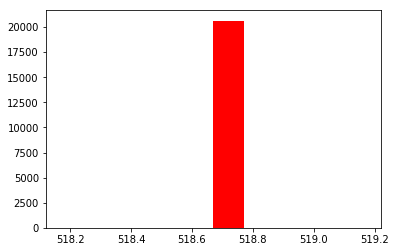

i_n_sensor_1


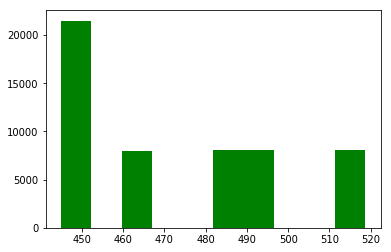

i_n_sensor_1


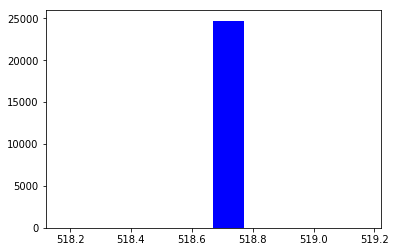

i_n_sensor_1


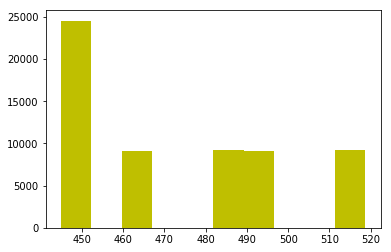

i_n_sensor_2


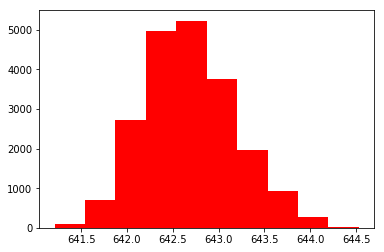

i_n_sensor_2


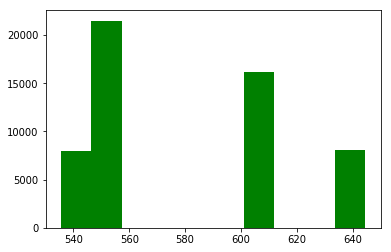

i_n_sensor_2


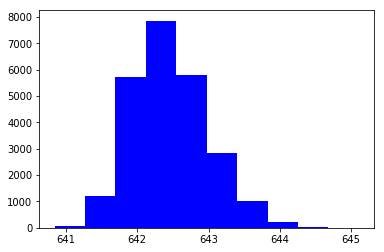

i_n_sensor_2


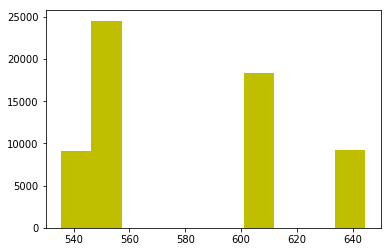

i_n_sensor_3


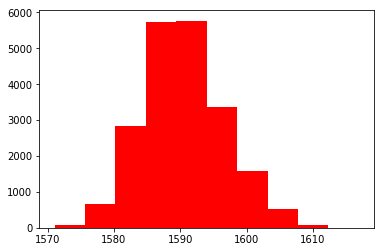

i_n_sensor_3


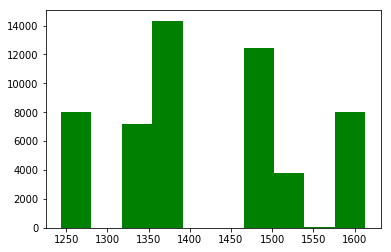

i_n_sensor_3


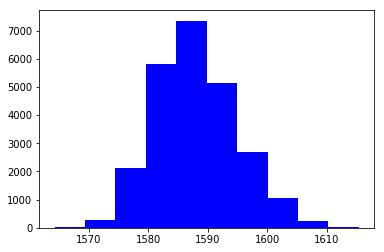

i_n_sensor_3


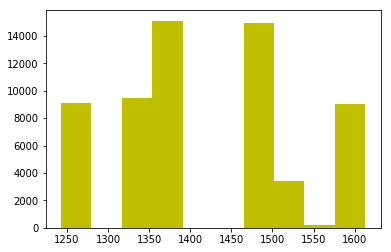

i_n_sensor_4


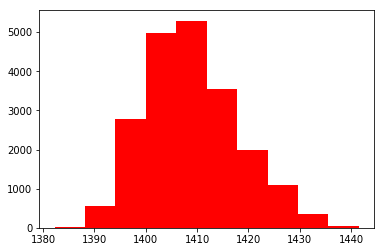

i_n_sensor_4


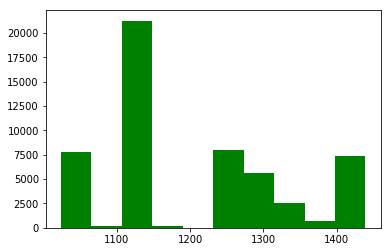

i_n_sensor_4


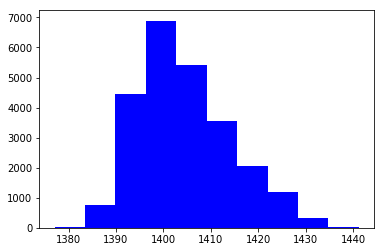

i_n_sensor_4


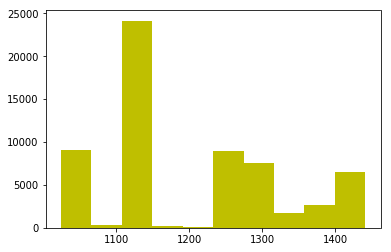

i_n_sensor_5


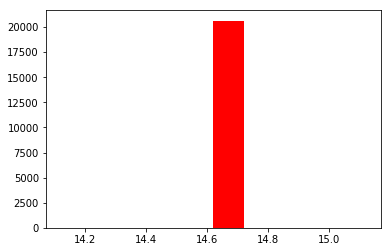

i_n_sensor_5


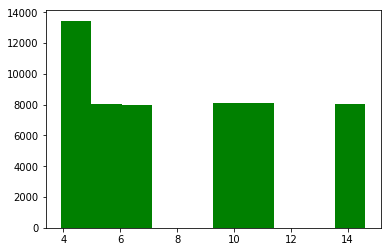

i_n_sensor_5


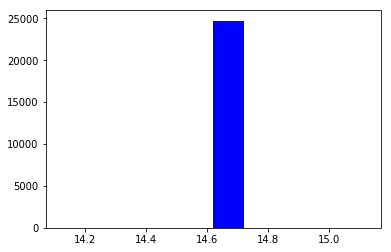

i_n_sensor_5


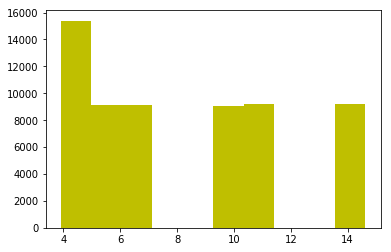

i_n_sensor_6


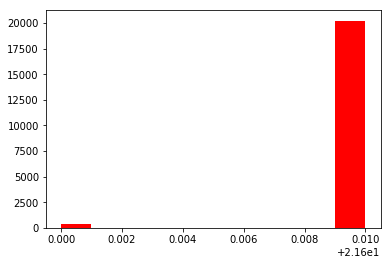

i_n_sensor_6


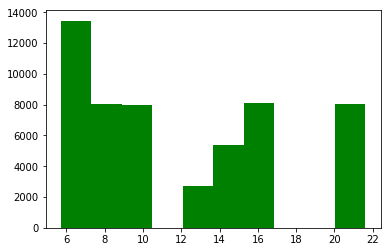

i_n_sensor_6


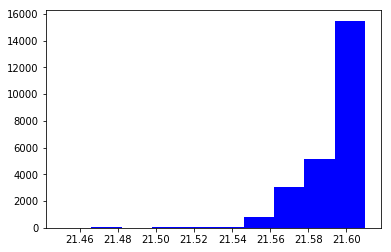

i_n_sensor_6


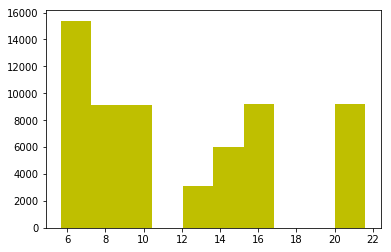

i_n_sensor_7


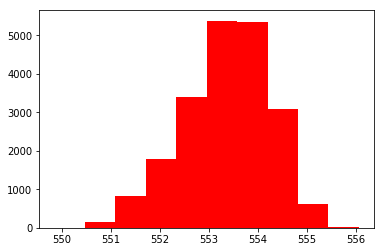

i_n_sensor_7


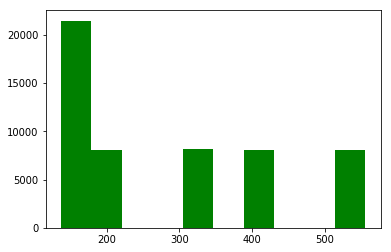

i_n_sensor_7


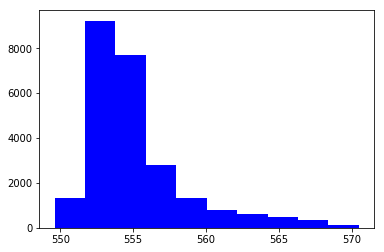

i_n_sensor_7


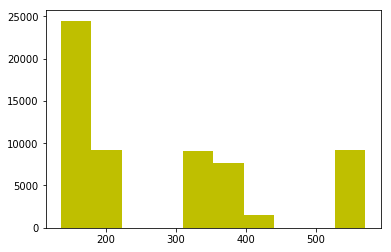

i_n_sensor_8


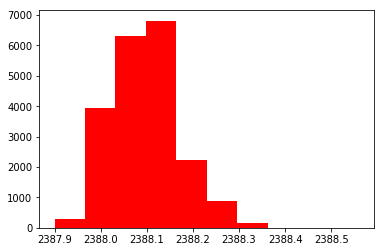

i_n_sensor_8


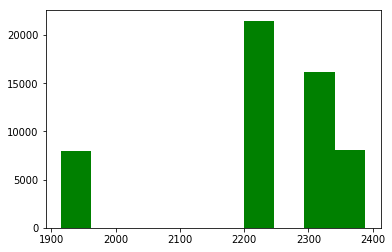

i_n_sensor_8


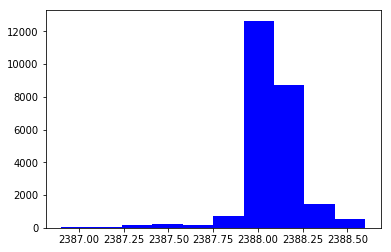

i_n_sensor_8


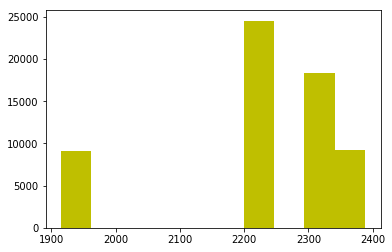

i_n_sensor_9


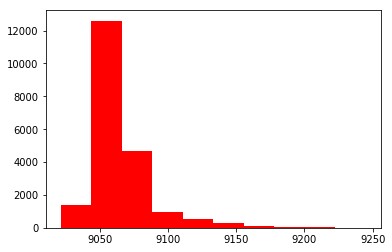

i_n_sensor_9


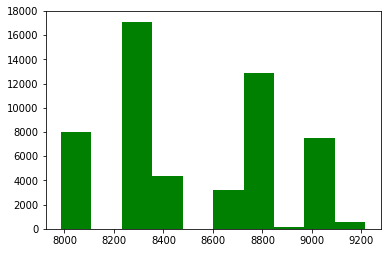

i_n_sensor_9


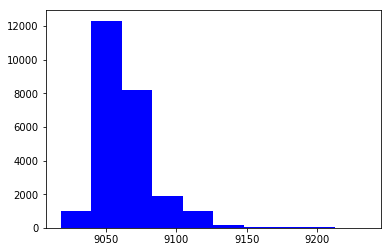

i_n_sensor_9


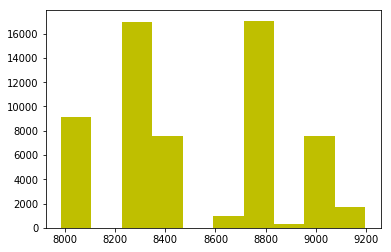

i_n_sensor_10


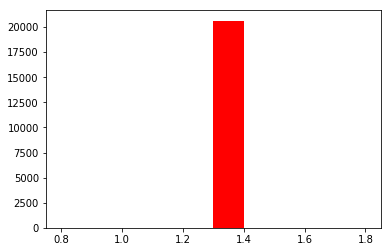

i_n_sensor_10


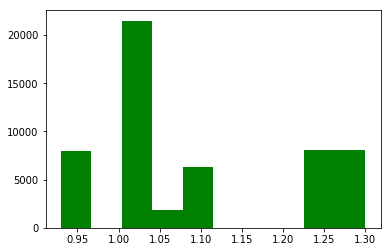

i_n_sensor_10


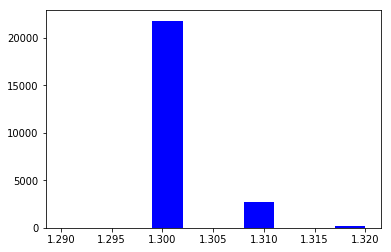

i_n_sensor_10


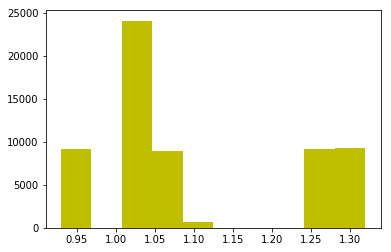

i_n_sensor_11


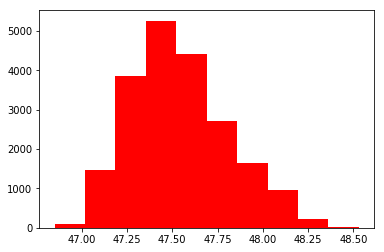

i_n_sensor_11


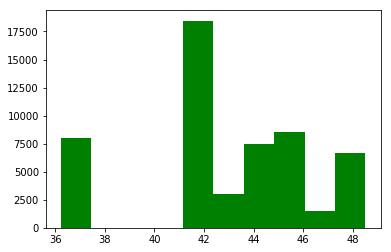

i_n_sensor_11


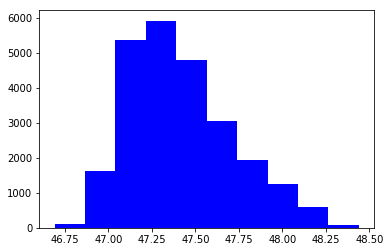

i_n_sensor_11


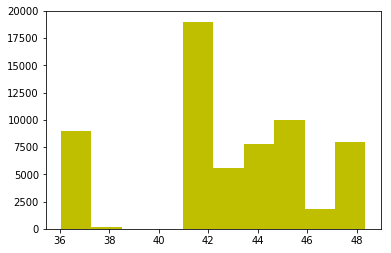

i_n_sensor_12


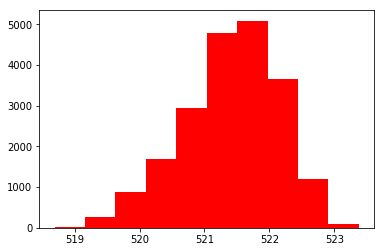

i_n_sensor_12


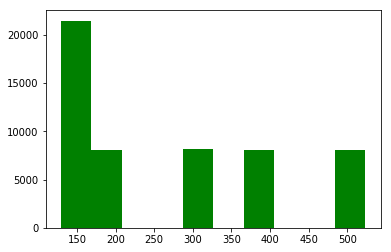

i_n_sensor_12


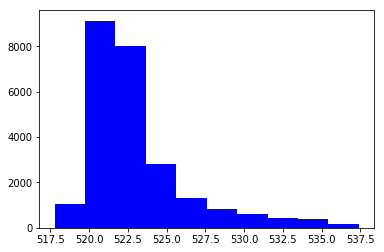

i_n_sensor_12


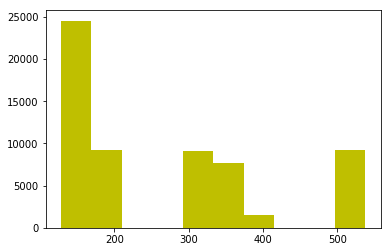

i_n_sensor_13


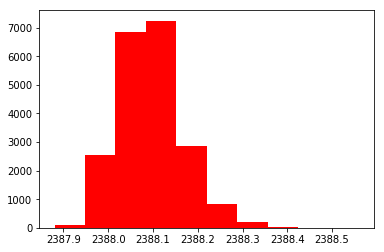

i_n_sensor_13


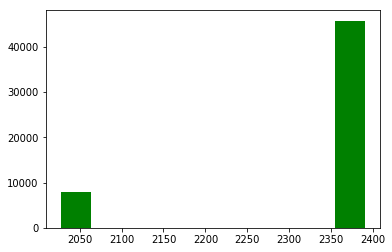

i_n_sensor_13


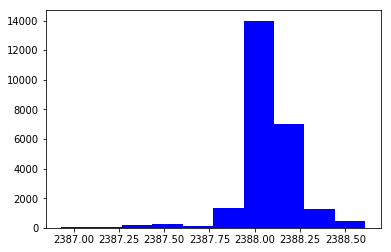

i_n_sensor_13


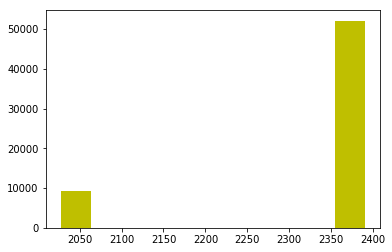

i_n_sensor_14


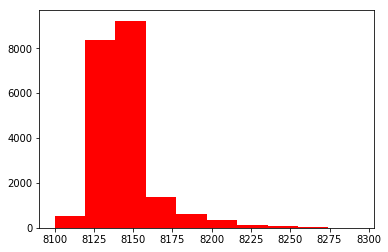

i_n_sensor_14


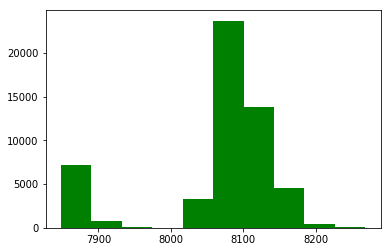

i_n_sensor_14


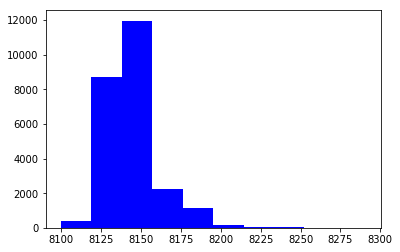

i_n_sensor_14


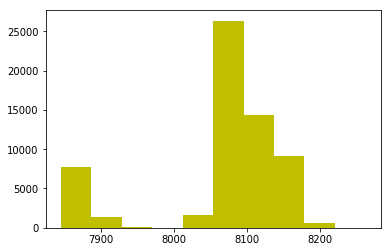

i_n_sensor_15


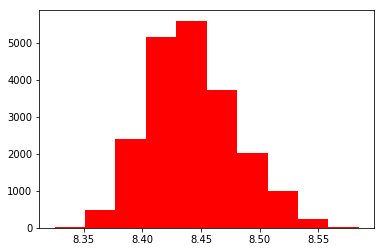

i_n_sensor_15


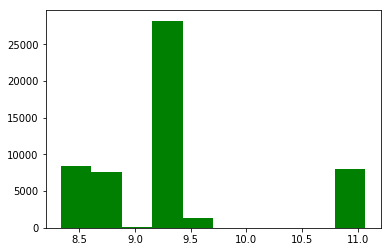

i_n_sensor_15


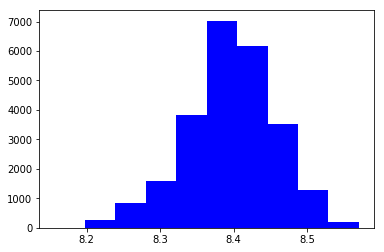

i_n_sensor_15


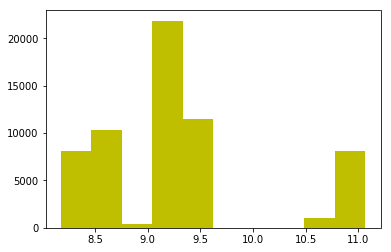

i_n_sensor_16


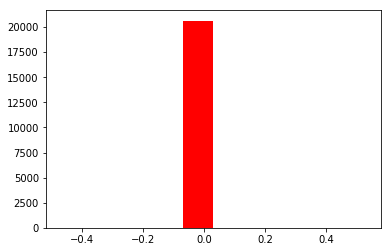

i_n_sensor_16


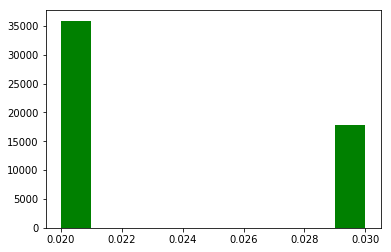

i_n_sensor_16


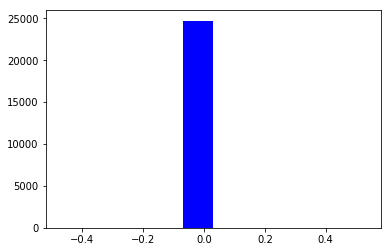

i_n_sensor_16


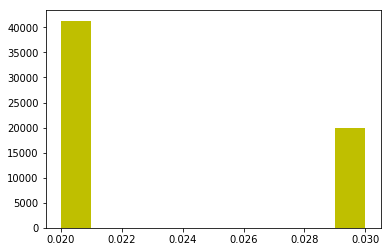

i_n_sensor_17


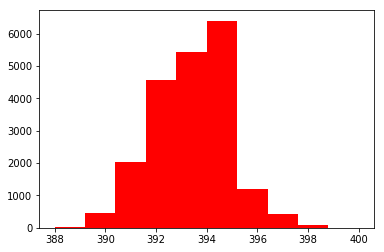

i_n_sensor_17


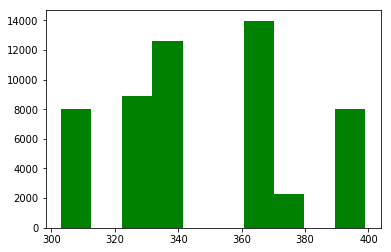

i_n_sensor_17


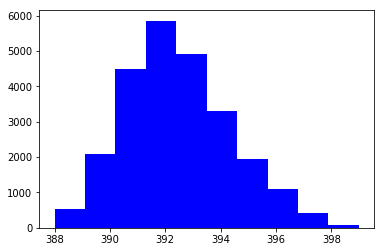

i_n_sensor_17


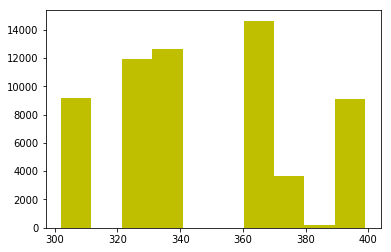

i_n_sensor_18


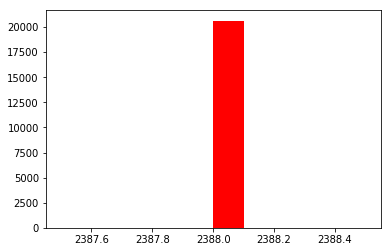

i_n_sensor_18


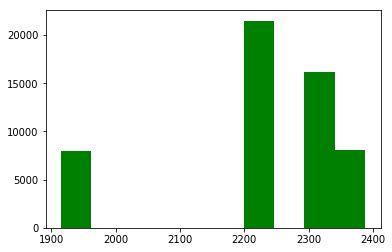

i_n_sensor_18


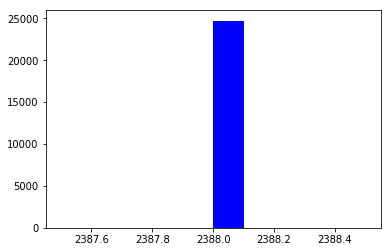

i_n_sensor_18


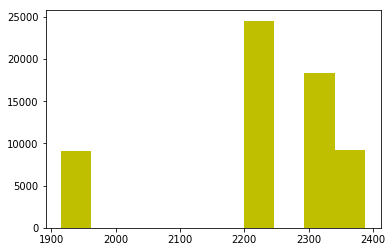

i_n_sensor_19


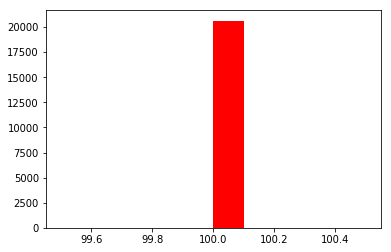

i_n_sensor_19


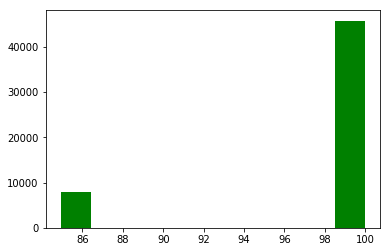

i_n_sensor_19


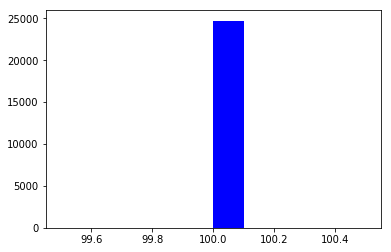

i_n_sensor_19


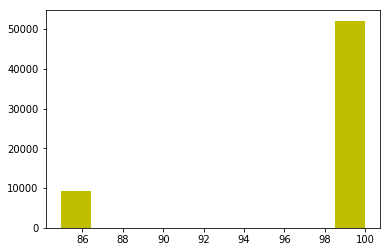

i_n_sensor_20


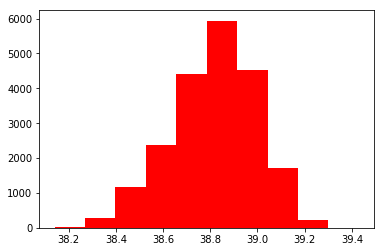

i_n_sensor_20


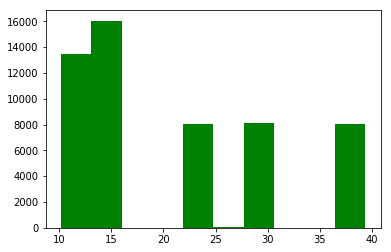

i_n_sensor_20


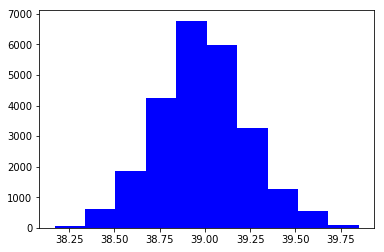

i_n_sensor_20


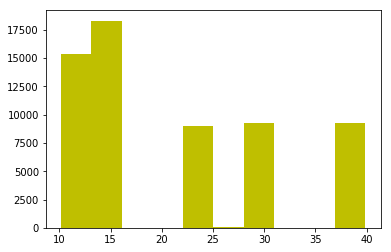

i_n_sensor_21


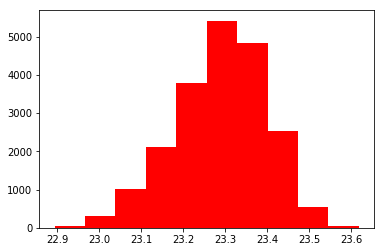

i_n_sensor_21


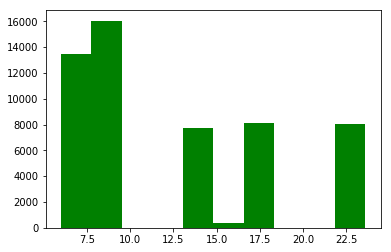

i_n_sensor_21


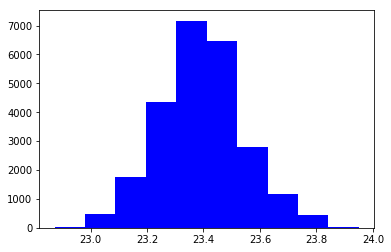

i_n_sensor_21


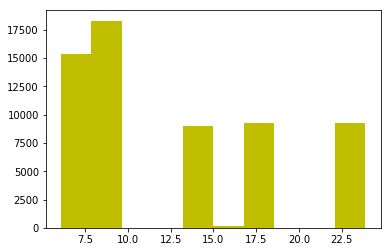

In [15]:
train_list = [train_df1,train_df2,train_df3,train_df4]

df_col = {1:'r',2:'g',3:'b',4:'y'}

# c = [c for c in train_df1.columns if 'sensor' in c][6]
# c

for c in [c for c in train_df1.columns if 'sensor' in c]:
    i = 0
    for df in train_list:
        print(c)
        i+=1
        plt.hist(df[c],color=df_col[i])
        plt.show()




In [16]:
# There are differences between the vaiables accross dfs So we must be carefull of joining the dfs

### Outliers

In [186]:
# Remove outliers when tehy are 3 std dev outside of norm

def rem_outl(df,c,sd):
    newdf = df[np.abs(df[c]-df[c].mean()) <= (sd*df[c].std())]
    print('Kept {}% of the data'.format(round(len(newdf)/len(df),4)*100))
    return newdf

In [187]:
tr1 = train_df1.copy()
tr2 = train_df2.copy()
tr3 = train_df3.copy()
tr4 = train_df4.copy()

for c in tr1.columns:
    print(c)
    tr1 = rem_outl(tr1,c,4)
    tr2 = rem_outl(tr2,c,3)
    tr3 = rem_outl(tr3,c,4)
    tr4 = rem_outl(tr4,c,3)


unit_number
Kept 100.0% of the data
Kept 100.0% of the data
Kept 100.0% of the data
Kept 100.0% of the data
cycle
Kept 100.0% of the data
Kept 99.59% of the data
Kept 100.0% of the data
Kept 99.4% of the data
i_n_os1
Kept 100.0% of the data
Kept 100.0% of the data
Kept 100.0% of the data
Kept 100.0% of the data
i_n_os2
Kept 100.0% of the data
Kept 100.0% of the data
Kept 100.0% of the data
Kept 100.0% of the data
i_n_os3
Kept 100.0% of the data
Kept 100.0% of the data
Kept 100.0% of the data
Kept 100.0% of the data
i_n_sensor_1
Kept 100.0% of the data
Kept 100.0% of the data
Kept 100.0% of the data
Kept 100.0% of the data
i_n_sensor_2
Kept 100.0% of the data
Kept 100.0% of the data
Kept 99.99% of the data
Kept 100.0% of the data
i_n_sensor_3
Kept 100.0% of the data
Kept 100.0% of the data
Kept 99.99% of the data
Kept 100.0% of the data
i_n_sensor_4
Kept 100.0% of the data
Kept 100.0% of the data
Kept 100.0% of the data
Kept 100.0% of the data
i_n_sensor_5
Kept 100.0% of the data
Kept 1

In [188]:
print('Kept {}% of the data for train_df1'.format(round(len(tr1)/len(train_df1),4)*100))
print()
print('Kept {}% of the data for train_df2'.format(round(len(tr2)/len(train_df2),4)*100))
print()
print('Kept {}% of the data for train_df3'.format(round(len(tr3)/len(train_df3),4)*100))
print()
print('Kept {}% of the data for train_df4'.format(round(len(tr4)/len(train_df4),4)*100))

Kept 96.24000000000001% of the data for train_df1

Kept 99.18% of the data for train_df2

Kept 95.66% of the data for train_df3

Kept 98.8% of the data for train_df4


In [189]:
tr_df1 = tr1.copy()
tr_df2 = tr2.copy()
tr_df3 = tr3.copy()
tr_df4 = tr4.copy()

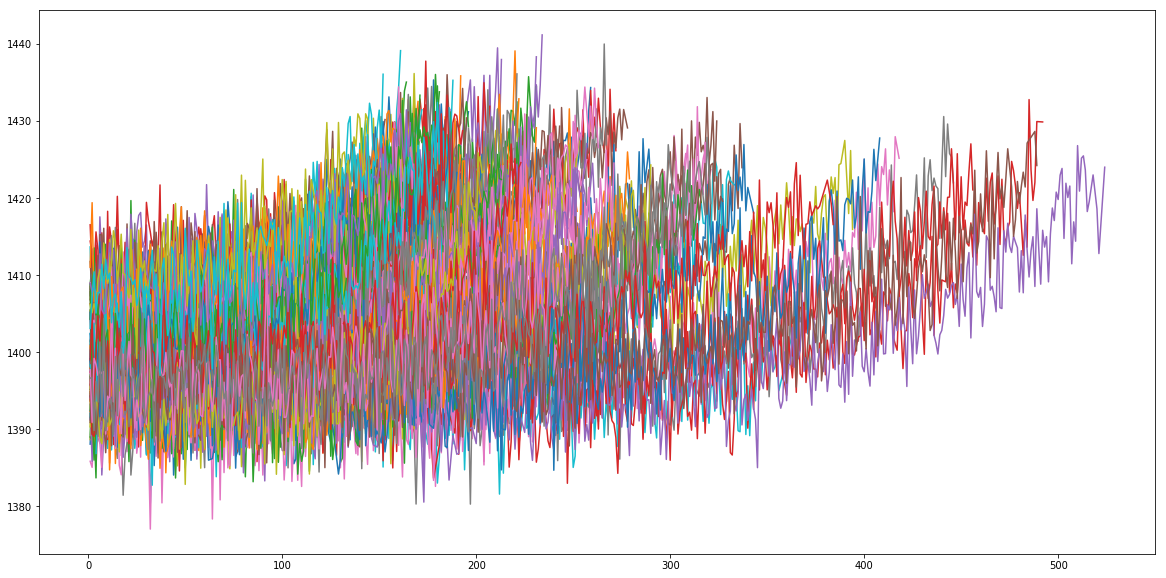

In [21]:
# for key, grp in tr_df3.groupby([entity]): 
#     plt.plot(grp[time_stamp], grp['i_n_sensor_4'], label = "Entity{}".format(key))
#     plt.gcf().set_size_inches(20, 10)
# plt.legend(loc='best')    

### Normalize Data

In [190]:
predictors_1 = [c for c in tr_df1 if 'i_n_' in c]
for c in predictors_1:
    tr_df1[c] = tr_df1[['unit_number',c]].groupby('unit_number').transform(lambda x: (x - x.mean()) / x.std())
    test_df1[c] = test_df1[['unit_number',c]].groupby('unit_number').transform(lambda x: (x - x.mean()) / x.std())
    
predictors_2 = [c for c in tr_df2 if 'i_n_' in c]
for c in predictors_2:
    tr_df2[c] = tr_df2[['unit_number',c]].groupby('unit_number').transform(lambda x: (x - x.mean()) / x.std())
    test_df2[c] = test_df2[['unit_number',c]].groupby('unit_number').transform(lambda x: (x - x.mean()) / x.std())
    
predictors_3 = [c for c in tr_df3 if 'i_n_' in c]
for c in predictors_3:
    tr_df3[c] = tr_df3[['unit_number',c]].groupby('unit_number').transform(lambda x: (x - x.mean()) / x.std())
    test_df3[c] = test_df3[['unit_number',c]].groupby('unit_number').transform(lambda x: (x - x.mean()) / x.std())
    
predictors_4 = [c for c in tr_df4 if 'i_n_' in c]
for c in predictors_4:
    tr_df4[c] = tr_df4[['unit_number',c]].groupby('unit_number').transform(lambda x: (x - x.mean()) / x.std())
    test_df4[c] = test_df4[['unit_number',c]].groupby('unit_number').transform(lambda x: (x - x.mean()) / x.std())

### Remove correlated Features

In [191]:
# Remove highly correlated features

def rem_ccf(df,limit,df_test):
    cr = df.corr()
    cols = [c for c in df if 'i_n_' in c]
    n = len(cols)
    passed = []
    
    for i in cols:
        passed.append(i)
        for j in [c for c in cols if c not in passed]:
            cor = float(cr.loc[i][j])
            
            if np.abs(cor) > limit:
                df.drop([j],axis=1,inplace=True)
                df_test.drop([j],axis=1,inplace=True)
                print('{} was dropped because it is {} correlated with {}'.format(j,cor,i))
                passed.append(j)

### Concat Dfs

In [192]:
train_df1_ph = tr_df1.copy()
test_df1_ph = test_df1.copy()

train_df2_ph = tr_df2.copy()
test_df2_ph = test_df2.copy()

train_df3_ph = tr_df3.copy()
test_df3_ph = test_df3.copy()

train_df4_ph = tr_df4.copy()
test_df4_ph = test_df4.copy()

# tr_df1 = train_df1_ph.copy()
# test_df1 = test_df1_ph.copy()

# tr_df2 = train_df2_ph.copy()
# test_df2 = test_df2_ph.copy()

# tr_df3 = train_df3_ph.copy()
# test_df3 = test_df3_ph.copy()

# tr_df4 = train_df4_ph.copy()
# test_df4 = test_df4_ph.copy()

In [193]:
DF_train = pd.concat([tr_df1,tr_df2,tr_df3,tr_df4],axis=0)
# DF_val = pd.concat([val_df1,val_df2,val_df3,val_df4],axis=0)
DF_test = pd.concat([test_df1,test_df2,test_df3,test_df4],axis=0)
DF_train.shape, DF_test.shape


# DF_train = tr_df2.copy()
# # DF_val = pd.concat([val_df1,val_df2,val_df3,val_df4],axis=0)
# DF_test = test_df2.copy()
# DF_train.shape, DF_test.shape

((157336, 27), (104897, 27))

In [194]:
# print('1')
# rem_ccf(tr_df1,0.99,test_df1)

# print('2')
# rem_ccf(tr_df2,0.99,test_df2)

# print('3')
# rem_ccf(tr_df3,0.99,test_df3)

# print('4')
# rem_ccf(tr_df4,0.99,test_df4)

rem_ccf(DF_train,0.99,DF_test)

i_n_sensor_13 was dropped because it is 0.9999986925915719 correlated with i_n_os3
i_n_sensor_19 was dropped because it is 0.9999999999999973 correlated with i_n_os3
i_n_sensor_18 was dropped because it is 0.9968766440609038 correlated with i_n_sensor_8


In [195]:
DF_train.shape

(157336, 24)

In [196]:
DF_test.shape

(104897, 24)

### Create Validation DF

In [197]:
p = 0.8

tr_df1 = DF_train.sample(frac=1).reset_index(drop=True)
n = int(len(tr_df1)*p)
DF_train = tr_df1[:n]
DF_val = tr_df1[n:]

# tr_df1 = tr_df1.sample(frac=1).reset_index(drop=True)
# n = int(len(tr_df1)*p)
# train_df1 = tr_df1[:n]
# val_df1 = tr_df1[n:]

# tr_df2 = tr_df2.sample(frac=1).reset_index(drop=True)
# n = int(len(tr_df2)*p)
# train_df2 = tr_df2[:n]
# val_df2 = tr_df2[n:]

# tr_df3 = tr_df3.sample(frac=1).reset_index(drop=True)
# n = int(len(tr_df3)*p)
# train_df3 = tr_df3[:n]
# val_df3 = tr_df3[n:]

# tr_df4 = tr_df4.sample(frac=1).reset_index(drop=True)
# n = int(len(tr_df4)*p)
# train_df4 = tr_df4[:n]
# val_df4 = tr_df4[n:]

In [198]:
DF_train.shape, DF_val.shape, DF_test.shape

((125868, 24), (31468, 24), (104897, 24))

In [199]:
DF_train = DF_train.fillna(-99)
DF_val = DF_val.fillna(-99)
DF_test = DF_test.fillna(-99)

In [200]:
import sagemaker
from sagemaker.amazon.amazon_estimator import get_image_uri 
from io import StringIO # python3; python2: BytesIO 
import boto3

### Save data to S3

In [201]:
csv_buffer1 = StringIO()
l = [target]
l.extend([c for c in DF_train.columns if 'i_n_' in c])
df1 = DF_train.copy()[l]
df1.to_csv(csv_buffer1,index=False)

csv_buffer2 = StringIO()
df1_v = DF_val.copy()[l]
df1_v.to_csv(csv_buffer2,index=False)

csv_buffer3 = StringIO()
df1_t = DF_test.copy()[l[1:]]
df1_t.to_csv(csv_buffer3,index=False,header=False)

s3_resource = boto3.resource('s3')
s3_resource.Object(bucket, 'model/train.csv').put(Body=csv_buffer1.getvalue())
s3_resource.Object(bucket, 'model/val.csv').put(Body=csv_buffer2.getvalue())
s3_resource.Object(bucket, 'model/test.csv').put(Body=csv_buffer3.getvalue())

{'ResponseMetadata': {'RequestId': 'DC4B72000F1E35D6',
  'HostId': 'xAD0hacCYe+ULyZxg5QlDr7PCSdl5P4EAt+T9of6drFnsk/rO/6TbSd/zYSIaHdI1ZoDI7NQAI0=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'xAD0hacCYe+ULyZxg5QlDr7PCSdl5P4EAt+T9of6drFnsk/rO/6TbSd/zYSIaHdI1ZoDI7NQAI0=',
   'x-amz-request-id': 'DC4B72000F1E35D6',
   'date': 'Thu, 31 Oct 2019 17:28:43 GMT',
   'etag': '"22f9e23d284dce8c25d236b73cc063d8"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"22f9e23d284dce8c25d236b73cc063d8"'}

### Run Model

In [82]:
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker import get_execution_role
role = get_execution_role()
print(role)
region = 'us-east-1'
container = get_image_uri(region, 'xgboost','0.90-1')
region,bucket

arn:aws:iam::023375022819:role/service-role/AmazonSageMaker-ExecutionRole-20191029T112723


('us-east-1', 'pm-rodrigo-bucket')

In [89]:
xgb_model = sagemaker.estimator.Estimator(container,
                                         role, 
                                         train_instance_count=1,  
                                         train_instance_type='ml.m4.xlarge',
                                         train_volume_size = 5,
                                         output_path='s3://{}/results'.format(bucket),
                                         sagemaker_session=sagemaker.Session())

In [90]:
xgb_model.set_hyperparameters(max_depth=5,
        eta=0.2,
        gamma=4,
        min_child_weight=6,
        subsample=0.7,
        silent=0,
        objective="reg:linear",
        num_round=50)


In [91]:
train_channel = sagemaker.session.s3_input('s3://{}/model/train.csv'.format(bucket), content_type='text/csv')
valid_channel = sagemaker.session.s3_input('s3://{}/model/val.csv'.format(bucket), content_type='text/csv')

data_channels = {'train': train_channel, 'validation': valid_channel}

In [92]:
# objective_metric_name = 'validation:auc'
# objective_metric_name = 'validation:logloss'
objective_metric_name = 'validation:rmse'

hyperparameter_ranges = {'eta': sagemaker.tuner.ContinuousParameter(0,1),
                        'min_child_weight':sagemaker.tuner.ContinuousParameter(1,10),
                        'alpha': sagemaker.tuner.ContinuousParameter(0,2),
                        'max_depth':sagemaker.tuner.IntegerParameter(1,10)}



In [93]:
tuner = sagemaker.tuner.HyperparameterTuner(xgb_model, objective_metric_name, hyperparameter_ranges, metric_definitions=None, 
strategy='Bayesian', objective_type='Minimize', max_jobs=20, max_parallel_jobs=5, tags=None, 
base_tuning_job_name=None, warm_start_config=None, early_stopping_type='Off')

In [94]:
tuner.fit(inputs=data_channels,  logs=True)

In [128]:
region = 'us-east-1'
container = get_image_uri(region, 'xgboost','0.90-1')
region,bucket

('us-east-1', 'pm-rodrigo-bucket')

In [129]:
xgb_model = sagemaker.estimator.Estimator(container,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.m4.xlarge',
                                         train_volume_size = 5,
                                         output_path='s3://{}/results'.format(bucket),
                                         sagemaker_session=sagemaker.Session())

In [130]:
xgb_model.set_hyperparameters(max_depth=10,
        eta=0.2956041219528114,
        gamma=4,
        min_child_weight=9.607493346079774,
        subsample=0.7,
        silent=0,
        objective="reg:linear",
        alpha = 1.935578680889933,
        num_round=50)

In [131]:
train_channel = sagemaker.session.s3_input('s3://{}/model/train.csv'.format(bucket), content_type='text/csv')
valid_channel = sagemaker.session.s3_input('s3://{}/model/val.csv'.format(bucket), content_type='text/csv')

data_channels = {'train': train_channel, 'validation': valid_channel}

In [132]:
xgb_model.fit(inputs=data_channels,  logs=True)

2019-10-31 16:36:51 Starting - Starting the training job...
2019-10-31 16:36:53 Starting - Launching requested ML instances......
2019-10-31 16:37:56 Starting - Preparing the instances for training......
2019-10-31 16:39:13 Downloading - Downloading input data
2019-10-31 16:39:13 Training - Downloading the training image...
2019-10-31 16:39:41 Training - Training image download completed. Training in progress.INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value reg:linear to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[16:39:40] 125869x21 matrix with 2643249 entries loaded from /opt/ml/inpu

In [137]:
batch_output = 's3://{}/pred'.format(bucket)
transformer = xgb_model.transformer(instance_count=1, instance_type='ml.m4.xlarge', output_path=batch_output)

# transformer = sagemaker.transformer.Transformer(model_name='sagemaker-xgboost-191031-1612-020-3782c714',instance_count=1, instance_type='ml.m4.xlarge', output_path=batch_output)


In [202]:
batch_input = 's3://{}/model/test.csv'.format(bucket)
# batch_input = 's3://{}/model/val.csv'.format(bucket)

transformer.transform(data=batch_input, data_type='S3Prefix', content_type='text/csv', split_type='Line')

In [203]:
y = DF_test[target]
# y = DF_val[target]

In [207]:
s3 = boto3.client('s3') 
obj = s3.get_object(Bucket= bucket, Key= 'pred/test.csv.out') 
pred = pd.read_csv(obj['Body'],header=None, delimiter=" ", low_memory=False)

In [208]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(y, pred))

In [209]:
rms

58.03906488225216